In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']
label_dict = dict([(l,i) for i, l in enumerate(labels)])

In [4]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [5]:
# volume1 = np.load(os.path.join(volume_dir, 'volume_MD589_labelmap.npz'))['arr_0']
volume1 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD589_annotation.bp'))[::2, ::2, ::2]
atlas_ydim, atlas_xdim, atlas_zdim = volume1.shape
print atlas_xdim, atlas_ydim, atlas_zdim

745 327 473


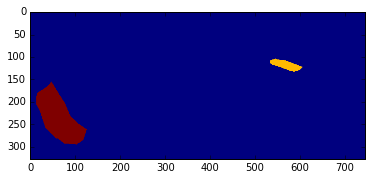

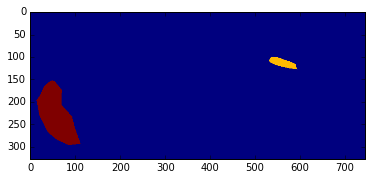

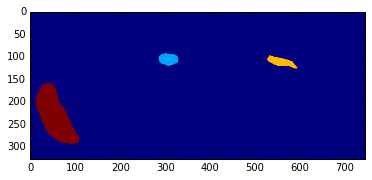

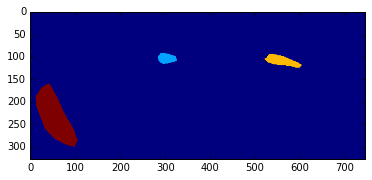

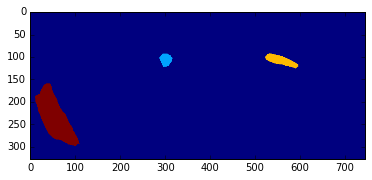

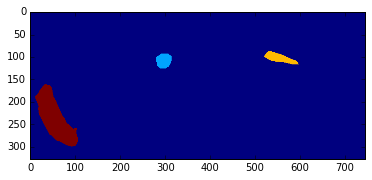

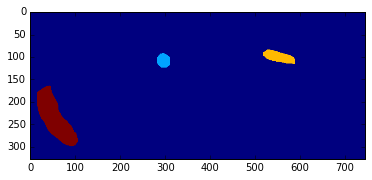

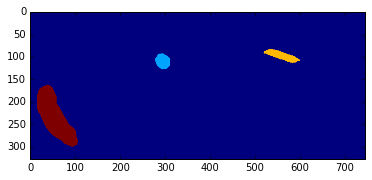

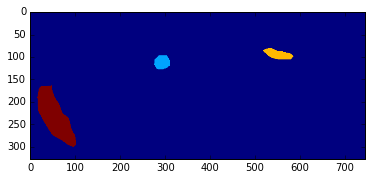

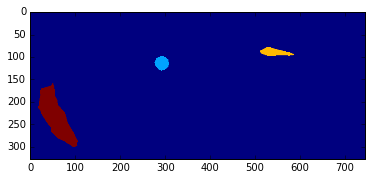

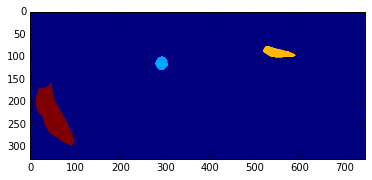

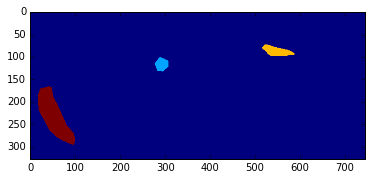

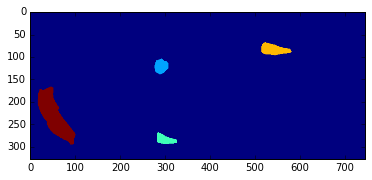

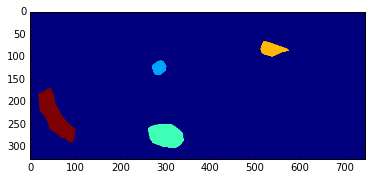

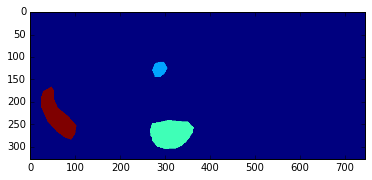

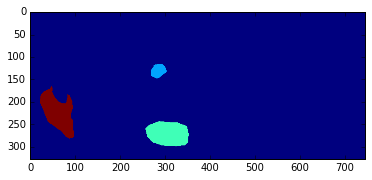

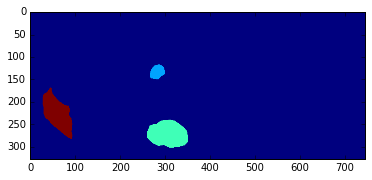

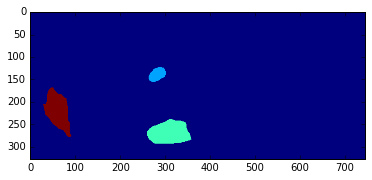

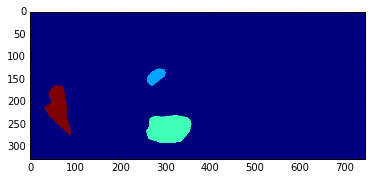

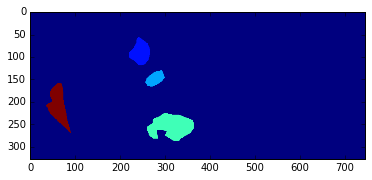

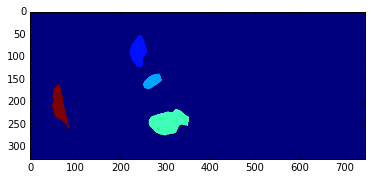

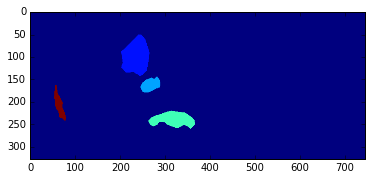

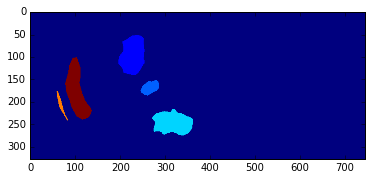

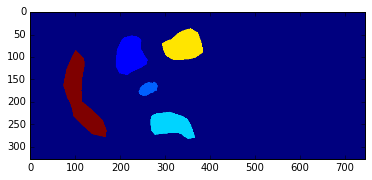

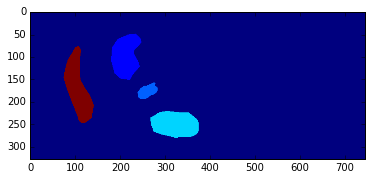

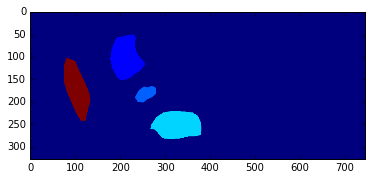

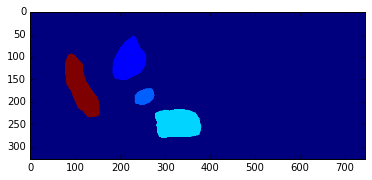

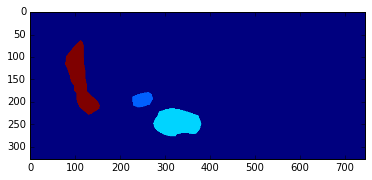

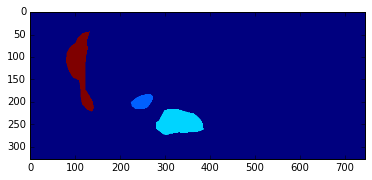

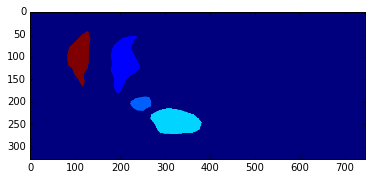

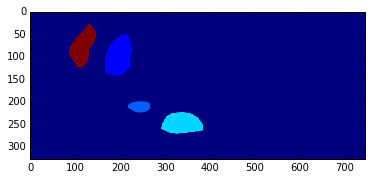

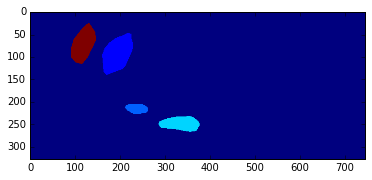

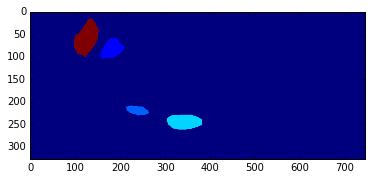

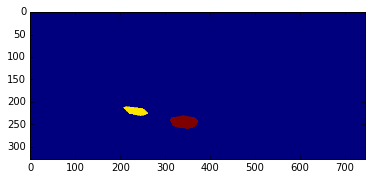

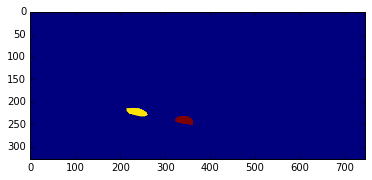

IndexError: index 475 is out of bounds for axis 2 with size 473

In [56]:
for z in range(300, 500, 5):
    plt.imshow(volume1[..., z])
    plt.show();

In [12]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

stack = 'MD595'
    
# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

if stack == 'MD594':
    roi_zmin, roi_zmax = (777/2, 1662/2)
elif stack == 'MD595':
    roi_zmin, roi_zmax = (312, 759)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - roi_zmin, int(z_xy_ratio_downsampled*(s+1)) - roi_zmin + 1):
        map_z_to_section[z] = s

67 330


In [13]:
# nzs = [np.where(v) for v in volume2_allLabels]
# [(np.min(v, axis=1), np.max(v, axis=1)) for v in nzs]

# if stack == 'MD594':
#     volume_xmin, volume_xmax = (119, 1785)
#     volume_ymin, volume_ymax = (483, 1391)
    
if stack == 'MD595':
    volume_xmin, volume_xmax = (123, 990)
    volume_ymin, volume_ymax = (287, 755)

In [29]:
volume2_allLabels = []

for l in range(1, 10):
#     volume2 = np.load(os.path.join(volume_dir, 'volume_MD594_scoreMap_%(label)d.npz'%{'label': l}))['arr_0']
    
    print labels[l]
    
    volume2 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_%(label)s.bp' % \
                                                  {'stack': stack, 'label': labels[l]}))
    
    volume2_cropped = volume2[volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1].copy()
    # copy is important, because then you can delete the large array

    volume2_allLabels.append(volume2_cropped)
    
    del volume2

5N
7n
7N
12N
Gr
LVe
Pn
SuVe
VLL


In [30]:
test_ydim, test_xdim, test_zdim = volume2_allLabels[0].shape

print test_xdim, test_ydim, test_zdim

test_centroid = (.5*test_xdim, .5*test_ydim, .5*test_ydim)
print test_centroid

test_cx, test_cy, test_cz = test_centroid

868 469 448
(434.0, 234.5, 234.5)


In [ ]:
# # z_level = 40
# # label = '7n'

# # dm = DataManager(stack=stack, section=map_z_to_section[z_level])
# # dm._load_image(versions=['rgb-jpg'])
# # viz1 = dm.image_rgb_jpg[::downsample_factor, ::downsample_factor][volume_ymin:volume_ymax+1, 
# #                                                                   volume_xmin:volume_xmax+1]
# # viz2 = colors[test_volume_atlas_projected[...,z]]
# viz3 = plt.cm.hot(volume2_allLabels[label_dict[label]-1][...,z_level])[...,:3]
# # viz = img_as_ubyte(alpha_blending(viz3, alpha_blending(viz2, viz1[...,:3], .2, 1.)[...,:3], .1, 1))
# viz = img_as_ubyte(alpha_blending(viz3, viz1[...,:3], .5, 1))

# display(viz)

# # figure, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(20,20))
# # axes[0].matshow(volume1[...,0]);
# # axes[1].matshow(volume2_allLabels[label_dict['5N']-1][...,10]);

In [ ]:
# plt.matshow(volume1[..., 65] == 1);

In [ ]:
# for z in range(0, volume1.shape[-1], 10):
#     plt.matshow(volume1[..., z] == 1);
#     plt.title('z = %d' % z)
#     plt.show();

In [31]:
from joblib import Parallel, delayed

In [32]:
def parallel_where(l):
    w = np.where(volume1 == l)
    return [w[1], w[0], w[2]]

import time
t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1,10))

print time.time() - t, 'seconds'

atlas_xmin, atlas_ymin, atlas_zmin = np.min([np.min(atlas_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
atlas_xmax, atlas_ymax, atlas_zmax = np.max([np.max(atlas_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
print atlas_xmin, atlas_xmax, atlas_ymin, atlas_ymax, atlas_zmin, atlas_zmax

atlas_centroid = np.array([.5*atlas_xmin+.5*atlas_xmax, .5*atlas_ymin+.5*atlas_ymax, .5*atlas_zmin+.5*atlas_zmax])
print atlas_centroid

atlas_cx, atlas_cy, atlas_cz = atlas_centroid

1.45868301392 seconds
0 743 0 326 0 472
[ 371.5  163.   236. ]


In [ ]:
# def parallel_where(l):
#     w = np.where(volume2_allLabels[l-1])
#     return [w[1], w[0], w[2]] # row,col,depth to x,y,z

# import time
# t = time.time()

# test_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1,10))

# # test_nzs = [np.where(volume2_allLabels[l-1]) for l in range(1,10)]
# # test_nzs = [[yxzs[1],yxzs[0],yxzs[2]] for yxzs in test_nzs]

# print time.time() - t, 'seconds'

# test_xmin, test_ymin, test_zmin = np.min([np.min(test_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
# test_xmax, test_ymax, test_zmax = np.max([np.max(test_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
# print test_xmin, test_xmax, test_ymin, test_ymax, test_zmin, test_zmax

# test_centroid = (.5*test_xmin+.5*test_xmax, .5*test_ymin+.5*test_ymax, .5*test_zmin+.5*test_zmax)
# print test_centroid

# del test_nzs

In [33]:
def quaternion_jacobian_points(qr,qx,qy,qz,x,y,z):
    
    dxdqr = 2*(-qz*y+qy*z)
    dxdqx = 2*qy*y+qz*z
    dxdqy = 2*(-2*qy*x+qx*y+qr*z)
    dxdqz = 2*(-2*qz*x-qr*y+qx*z)
    
    dydqr = 2*(qz*x-qx*z)
    dydqx = 2*(qy*x-2*qx*y-qr*z)
    dydqy = 2*(qx*x+qz*z)
    dydqz = 2*(qr*x-2*qz*y+qy*z)
    
    dzdqr = 2*(-qy*x+qx*y)
    dzdqx = 2*(qz*x+qr*y-2*qx*z)
    dzdqy = 2*(-qr*x+qz*y-2*qy*z)
    dzdqz = 2*(qx*x+qy*y)

    J = np.array([[dxdqr, dxdqr, dxdqr, dxdqr]]) * \
           quarternion_normalization_jacobian(qr,qx,qy,qz)
    
    return J

In [34]:
def quaternion_jacobian(qr,qx,qy,qz,x,y,z):

    J = np.dot(2*np.array([[-qz*y+qy*z, qy*y+qz*z, -2*qy*x+qx*y+qr*z, -2*qz*x-qr*y+qx*z],
                [qz*x-qx*z, qy*x-2*qx*y-qr*z, qx*x+qz*z, qr*x-2*qz*y+qy*z],
                [-qy*x+qx*y, qz*x+qr*y-2*qx*z, -qr*x+qz*y-2*qy*z, qx*x+qy*y]]),
           quarternion_normalization_jacobian(qr,qx,qy,qz))
    
    return J

In [35]:
def quarternion_to_matrix(qr,qx,qy,qz):
    qr2 = qr**2
    qx2 = qx**2
    qy2 = qy**2
    qz2 = qz**2
    qxqy = qx*qy
    qxqz = qx*qz
    qyqz = qy*qz
    qrqz = qr*qz
    qrqx = qr*qx
    qrqy = qr*qy
    R = np.array([[qr2+qx2-qy2-qz2, 2*(qxqy-qrqz), 2*(qxqz+qrqy)],
                  [2*(qxqy+qrqz), qr2-qx2+qy2-qz2, 2*(qyqz-qrqx)],
                  [2*(qxqz-qrqy), 2*(qyqz+qrqx), qr2-qx2-qy2+qz2]])
    return R

In [36]:
def score_transform(tx, ty, tz, qr, qx, qy, qz):
    
    R = quarternion_to_matrix(qr, qx, qy, qz)
                
    scores = np.empty((9,))
    for l in range(1,10):
                    
        test_xs, test_ys, test_zs = (np.dot(R, np.array(atlas_nzs[l-1]) - atlas_centroid[:, np.newaxis]) + \
                                    np.asarray([tx + test_cx, 
                                                ty + test_cy, 
                                                tz + test_cz])[:,np.newaxis]).astype(np.int)

        ydim, xdim, zdim = volume2_allLabels[l-1].shape

        valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
                (test_ys < ydim) & (test_xs < xdim) & (test_zs < zdim)

        voxel_probs_valid = volume2_allLabels[l-1][test_ys[valid], test_xs[valid], test_zs[valid]] / 1e4
        
#         assert np.count_nonzero(np.isinf(voxel_probs_valid)) == 0
        
#         print l, np.count_nonzero(np.isinf(voxel_probs_valid)), voxel_probs_valid.sum()
        
        scores[l-1] = voxel_probs_valid.sum()
        
#         assert not np.isinf(scores[l-1])
        
    score = np.sum(scores)
    return score

In [37]:
def quarternion_normalization_jacobian(qr,qx,qy,qz):
    
    qr2 = qr**2
    qx2 = qx**2
    qy2 = qy**2
    qz2 = qz**2
    qxqy = qx*qy
    qxqz = qx*qz
    qyqz = qy*qz
    qrqz = qr*qz
    qrqx = qr*qx
    qrqy = qr*qy
    
    D = np.array([[qx2+qy2+qz2, -qrqx, -qrqy, -qrqz],
                 [-qrqx, qr2+qy2+qz2, -qxqy, -qxqz],
                 [-qrqy, -qxqy, qr2+qx2+qz2, -qyqz],
                 [-qrqz, -qxqz, -qyqz, qr2+qx2+qy2]])
    
    J = 1./np.sqrt(qr2+qx2+qy2+qz2)**3*D
    
    return J
    

In [ ]:
# def score_transform(tx, ty, tz, theta_z, theta_y, theta_x):
    
#     cos_z = np.cos(theta_z)
#     sin_z = np.sin(theta_z)
#     cos_y = np.cos(theta_y)
#     sin_y = np.sin(theta_y)
#     cos_x = np.cos(theta_x)
#     sin_x = np.sin(theta_x)
#     Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
#     Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
#     Rx = np.array([[1, 0, 0], [0, cos_x, -sin_x], [0, sin_x, cos_x]])
#     R = np.dot(np.dot(Rz, Ry), Rx)
    
#     scores = np.empty((9,))
#     for l in range(1,10):

# #         test_xs, test_ys, test_zs = (np.dot(R, atlas_nzs[l-1]) + \
# #                                  np.asarray([tx, ty, tz])[:,np.newaxis]).astype(np.int)
        
                    
#         test_xs, test_ys, test_zs = (np.dot(R, atlas_nzs[l-1] - atlas_centroid[:, np.newaxis]) + \
#                                     np.asarray([tx + test_cx, 
#                                                 ty + test_cy, 
#                                                 tz + test_cz])[:,np.newaxis]).astype(np.int)

#         ydim, xdim, zdim = volume2_allLabels[l-1].shape

#         valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
#                 (test_ys < ydim) & (test_xs < xdim) & (test_zs < zdim)

#         voxel_probs_valid = volume2_allLabels[l-1][test_ys[valid], test_xs[valid], test_zs[valid]]
#         scores[l-1] = voxel_probs_valid.sum()

#     score = np.sum(scores)
#     return score

In [ ]:
# grid search

In [41]:
params2_best_upToNow = (0, 0, 0, 0,0, np.deg2rad(0))
score_best_upToNow = 0

for iteration in range(5):
    
    print iteration

    init_tx, init_ty, init_tz, init_vx, init_vy, init_theta  = params2_best_upToNow
    
    n = int(1000*np.exp(-iteration/2.))
    
    sigma_tx = 300*np.exp(-iteration/.3)
    sigma_ty = 300*np.exp(-iteration/.3)
    sigma_tz = 200*np.exp(-iteration/.3)
    
    sigma_v = .1 # axis of rotation
    sigma_theta = np.deg2rad(30*np.exp(-iteration/.6))
    
    tx_grid = init_tx + sigma_tx * (2 * np.random.random(n) - 1)
    ty_grid = init_ty + sigma_ty * (2 * np.random.random(n) - 1)
    tz_grid = init_tz + sigma_tz * (2 * np.random.random(n) - 1)
    vx_grid = init_vx + sigma_v * (2 * np.random.random(n) - 1)
    vy_grid = init_vy + sigma_v * (2 * np.random.random(n) - 1)
    theta_grid = init_theta + sigma_theta * (2 * np.random.random(n) - 1)

    qr_grid = np.cos(theta_grid/2)
    qx_grid = np.sin(theta_grid/2)*vx_grid
    qy_grid = np.sin(theta_grid/2)*vy_grid
    
    vz_grid = np.sqrt(1-vx_grid**2-vy_grid**2)
    qz_grid = np.sin(theta_grid/2)*vz_grid
    
    samples = np.c_[tx_grid, ty_grid, tz_grid, qr_grid, qx_grid, qy_grid, qz_grid]
    
    q_norm = np.sqrt(qr_grid**2 + qx_grid**2 + qy_grid**2 + qz_grid**2)
    qr_grid = qr_grid / q_norm 
    qx_grid = qx_grid / q_norm 
    qy_grid = qy_grid / q_norm 
    qz_grid = qz_grid / q_norm 
    
    import time
    t = time.time()
    
    scores = Parallel(n_jobs=16)(delayed(score_transform)(tx, ty, tz, qr, qx, qy, qz ) 
                                 for tx, ty, tz, qr, qx, qy, qz in samples)
#     scores = [score_transform(tx, ty, tz, qr, qx, qy, qz) for tx, ty, tz, qr, qx, qy, qz in samples]

    print time.time() - t, 'seconds'

    score_best = np.max(scores)

    tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best = samples[np.argmax(scores)]
    
    if score_best > score_best_upToNow:
        print score_best_upToNow, score_best

        score_best_upToNow = score_best
        params_best_upToNow = tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best
        
        v_best = np.array([qx_best,qy_best,qz_best])/np.sqrt(qx_best**2+qy_best**2+qz_best**2)
        theta_best = np.arccos(qr_best)
        
        params2_best_upToNow = tx_best, ty_best, tz_best, v_best[0], v_best[1], theta_best
        
        print tx_best, ty_best, tz_best, v_best, np.rad2deg(theta_best)

0
38.1571688652 seconds
0 25.5906741869
5.15695263534 16.5755782618 18.6996132976 [-0.03098457  0.0374299  -0.99881878] 9.93517200427
1
26.5220780373 seconds
2
15.8887820244 seconds
3
9.86654400826 seconds
4
6.24657583237 seconds


In [42]:
params_best_upToNow

(5.1569526353421491,
 16.575578261773273,
 18.699613297609162,
 0.9850035989015602,
 -0.0053458860764988526,
 0.0064579218257568597,
 -0.17232999419347689)

In [ ]:
# params_best_upToNow = (0, 0, 300, np.deg2rad(15), np.deg2rad(0), np.deg2rad(0))
# score_best_upToNow = 0

# for iteration in range(1):
    
#     print iteration

#     init_tx, init_ty, init_tz, init_theta_z, init_theta_y, init_theta_x = params_best_upToNow
    
#     # tx_grid = np.linspace(init_tx-400,init_tx+400,10)
#     # ty_grid = np.linspace(init_ty-400,init_ty+400,10)
#     # tz_grid = np.linspace(init_tz-200,init_tz+200,10)
#     # theta_z_grid = np.deg2rad(np.linspace(init_theta_z-20,init_theta_z+20,5))
#     # theta_y_grid = np.deg2rad(np.linspace(init_theta_y-20,init_theta_y+20,5))

#     n = int(200*np.exp(-iteration/2.))

#     # tx_grid = np.random.randint(init_tx-400, init_tx+400, n)
#     # ty_grid = np.random.randint(init_ty-400, init_ty+400, n)
#     # tz_grid = np.random.randint(init_tz-200, init_tz+200, n)
#     # theta_z_grid = np.deg2rad(np.random.randint(-20, 20, n))
#     # theta_y_grid = np.deg2rad(np.random.randint(-20, 20, n))

#     sigma_tx = 300*np.exp(-iteration/.3)
#     sigma_ty = 300*np.exp(-iteration/.3)
#     sigma_tz = 200*np.exp(-iteration/.3)
#     sigma_theta_z = np.deg2rad(20*np.exp(-iteration/.6))
#     sigma_theta_y = np.deg2rad(20*np.exp(-iteration/.6))
#     sigma_theta_x = np.deg2rad(20*np.exp(-iteration/.6))
   
# #     tx_grid = sigma_tx * np.random.randn(n) + init_tx
# #     ty_grid = sigma_ty * np.random.randn(n) + init_ty
# #     tz_grid = sigma_tz * np.random.randn(n) + init_tz
# #     theta_z_grid = sigma_theta_z * np.random.randn(n) + init_theta_z
# #     theta_y_grid = sigma_theta_y * np.random.randn(n) + init_theta_y

#     tx_grid = np.random.randint(init_tx-sigma_tx, init_tx+sigma_tx, n)
#     ty_grid = np.random.randint(init_ty-sigma_ty, init_ty+sigma_ty, n)
#     tz_grid = np.random.randint(init_tz-sigma_tz, init_tz+sigma_tz, n)
#     theta_z_grid = 2*sigma_theta_z*np.random.random(n) - sigma_theta_z
#     theta_y_grid = 2*sigma_theta_y*np.random.random(n) - sigma_theta_y
#     theta_x_grid = 2*sigma_theta_x*np.random.random(n) - sigma_theta_x

#     import time
#     t = time.time()

#     scores = Parallel(n_jobs=16)(delayed(score_transform)(tx, ty, tz, theta_z, theta_y, theta_x ) 
#                  for tx, ty, tz, theta_z, theta_y, theta_x in zip(tx_grid, ty_grid, tz_grid, 
#                                                     theta_z_grid, theta_y_grid, theta_x_grid))

#     print time.time() - t, 'seconds'

#     score_best = np.max(scores)

#     tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best = \
#     zip(tx_grid, ty_grid, tz_grid, theta_z_grid, theta_y_grid, theta_x_grid)[np.argmax(scores)]
    
#     if score_best > score_best_upToNow:
#         print score_best_upToNow, score_best

#         score_best_upToNow = score_best
#         params_best_upToNow = tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best
        
#         print tx_best, ty_best, tz_best, np.rad2deg(theta_z_best), np.rad2deg(theta_y_best), np.rad2deg(theta_x_best)

In [43]:
dSdyxz = []
for l in range(1, 10):
    print l
    import time
    t = time.time()
    dSdyxz.append(np.gradient(volume2_allLabels[l-1], 10, 10, 10))
    print time.time() - t, 'seconds'

1
3.38051509857 seconds
2
3.37624883652 seconds
3
3.36609792709 seconds
4
3.35953903198 seconds
5
3.38621091843 seconds
6
3.36068105698 seconds
7
3.36479902267 seconds
8
3.36287713051 seconds
9
3.38233804703 seconds


In [ ]:
# dSdyxz = []
# for l in range(1, 10):
#     print l
#     dSldyxz = []
#     for s in ['y', 'x', 'z']:
#         print s
#         gradient_filepath = os.path.join(volume_dir, 'volume_MD594_scoreMap_%(label)s_d%(p)s.bp' % \
#                                      {'label':labels[l], 'p': s})
#         dSldyxz.append(bp.unpack_ndarray_file(gradient_filepath))
#     dSdyxz.append(dSldyxz)

In [ ]:
# def parallel_gradient(l):
#     return np.gradient(volume2_allLabels[l-1], 10, 10, 10)

# import time
# t = time.time()

# dSdyxz = Parallel(n_jobs=16)(delayed(parallel_gradient)(l) for l in range(1,10))

# print time.time() - t, 'seconds'

In [ ]:
# dSdyxz = [np.gradient(volume2_allLabels[l-1], 10, 10, 10) for l in range(1, 10)]

In [44]:
def optimal_global_rigid_params(init_params, iter_num=100, return_scores=False, lr=(.01, 1e-6)):
    
#     master_stepsize = 1e-2 #for example
    fudge_factor = 1e-6 #for numerical stability
    
    dMdu_historical = 0
    dMdv_historical = 0
    dMdw_historical = 0
    dMdqr_historical = 0
    dMdqx_historical = 0
    dMdqy_historical = 0
    dMdqz_historical = 0
    
    lr1, lr2 = lr
    
    score_best = 0
    
    tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best = init_params
    
    scores = []
    
    for iteration in range(iter_num):

        dMdu = 0
        dMdv = 0
        dMdw = 0
        dMdqr = 0
        dMdqx = 0
        dMdqy = 0
        dMdqz = 0
        
        R_best = quarternion_to_matrix(qr_best, qx_best, qy_best, qz_best)
        
        for l in range(1, 10):
            
            ds = np.array(atlas_nzs[l-1]) - atlas_centroid[:, np.newaxis]
            
            xs_prime, ys_prime, zs_prime = (np.dot(R_best, atlas_nzs[l-1] - atlas_centroid[:, np.newaxis]) + \
                                            np.asarray([tx_best + test_cx, 
                                                        ty_best + test_cy, 
                                                        tz_best + test_cz])[:,np.newaxis]).astype(np.int)

            valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
                (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

            if np.count_nonzero(valid) > 0:
                
                xs_prime_valid = xs_prime[valid]
                ys_prime_valid = ys_prime[valid]
                zs_prime_valid = zs_prime[valid]
                                
                Sx = dSdyxz[l-1][1][ys_prime_valid, xs_prime_valid, zs_prime_valid]
                Sy = dSdyxz[l-1][0][ys_prime_valid, xs_prime_valid, zs_prime_valid]
                Sz = dSdyxz[l-1][2][ys_prime_valid, xs_prime_valid, zs_prime_valid]

                dMdu += Sx.sum()
                dMdv += Sy.sum()
                dMdw += Sz.sum()

                ds_valid = ds[:, valid]
                xs, ys, zs = ds_valid
                
                qn_jac = quarternion_normalization_jacobian(qr_best,qx_best,qy_best,qz_best)
                
                qr = qr_best
                qx = qx_best
                qy = qy_best
                qz = qz_best
                
                dxdqr = 2*(-qz*ys+qy*zs)
                dxdqx = 2*qy*ys+qz*zs
                dxdqy = 2*(-2*qy*xs+qx*ys+qr*zs)
                dxdqz = 2*(-2*qz*xs-qr*ys+qx*zs)

                dydqr = 2*(qz*xs-qx*zs)
                dydqx = 2*(qy*xs-2*qx*ys-qr*zs)
                dydqy = 2*(qx*xs+qz*zs)
                dydqz = 2*(qr*xs-2*qz*ys+qy*zs)

                dzdqr = 2*(-qy*xs+qx*ys)
                dzdqx = 2*(qz*xs+qr*ys-2*qx*zs)
                dzdqy = 2*(-qr*xs+qz*ys-2*qy*zs)
                dzdqz = 2*(qx*xs+qy*ys)

                dxdq = np.dot(np.c_[dxdqr, dxdqx, dxdqy, dxdqz], qn_jac)
                dydq = np.dot(np.c_[dydqr, dydqx, dydqy, dydqz], qn_jac)
                dzdq = np.dot(np.c_[dzdqr, dzdqx, dzdqy, dzdqz], qn_jac)
                
                dx2dqr = dxdq[:,0]
                dx2dqx = dxdq[:,1]
                dx2dqy = dxdq[:,2]
                dx2dqz = dxdq[:,3]
                
                dy2dqr = dydq[:,0]
                dy2dqx = dydq[:,1]
                dy2dqy = dydq[:,2]
                dy2dqz = dydq[:,3]
                
                dz2dqr = dzdq[:,0]
                dz2dqx = dzdq[:,1]
                dz2dqy = dzdq[:,2]
                dz2dqz = dzdq[:,3]
                
                dMdqr += np.dot(Sx, dx2dqr) + np.dot(Sy, dy2dqr) + np.dot(Sz, dz2dqr)
                dMdqx += np.dot(Sx, dx2dqx) + np.dot(Sy, dy2dqx) + np.dot(Sz, dz2dqx)
                dMdqy += np.dot(Sx, dx2dqy) + np.dot(Sy, dy2dqy) + np.dot(Sz, dz2dqy)
                dMdqz += np.dot(Sx, dx2dqz) + np.dot(Sy, dy2dqz) + np.dot(Sz, dz2dqz)
                                

        print '(dMdu, dMdv, dMdw):', dMdu, dMdv, dMdw
        print '(dMdqr, dMdqx, dMdqy, dMdqz):', dMdqr, dMdqx, dMdqy, dMdqz

        dMdu_historical += dMdu**2
        dMdv_historical += dMdv**2
        dMdw_historical += dMdw**2
        dMdqr_historical += dMdqr**2
        dMdqx_historical += dMdqx**2
        dMdqy_historical += dMdqy**2
        dMdqz_historical += dMdqz**2
        
        dMdu_adjusted = dMdu / (fudge_factor + np.sqrt(dMdu_historical))
        dMdv_adjusted = dMdv / (fudge_factor + np.sqrt(dMdv_historical))
        dMdw_adjusted = dMdw / (fudge_factor + np.sqrt(dMdw_historical))
        dMdqr_adjusted = dMdqr / (fudge_factor + np.sqrt(dMdqr_historical))
        dMdqx_adjusted = dMdqx / (fudge_factor + np.sqrt(dMdqx_historical))
        dMdqy_adjusted = dMdqy / (fudge_factor + np.sqrt(dMdqy_historical))
        dMdqz_adjusted = dMdqz / (fudge_factor + np.sqrt(dMdqz_historical))
        
#         lr1 = .1 * np.exp(-iteration/10.)
#     #     lr1 = 10. * np.exp(-iteration/10.)
#         lr2 = 1e-6 * np.exp(-iteration/5.)
        print 'lr1:', lr1, 'lr2:', lr2
        tx_best += lr1*dMdu_adjusted
        ty_best += lr1*dMdv_adjusted
        tz_best += lr1*dMdw_adjusted
        qr_best += lr2*dMdqr_adjusted
        qx_best += lr2*dMdqx_adjusted
        qy_best += lr2*dMdqy_adjusted
        qz_best += lr2*dMdqz_adjusted

        print '(dMdu, dMdv, dMdw) adjusted:', dMdu_adjusted, dMdv_adjusted, dMdw_adjusted
        print '(dMdqr, dMdqx, dMdqy, dMdqz) adjusted:', dMdqr_adjusted, dMdqx_adjusted, dMdqy_adjusted, dMdqz_adjusted
        
        
        print '(tx_best, ty_best, tz_best):', tx_best, ty_best, tz_best
        print '(qr_best, qx_best, qy_best, qz_best):', qr_best, qx_best, qy_best, qz_best
        
        
        qn = np.sqrt(qr_best**2 + qx_best**2 + qy_best**2 + qz_best**2)
        qx_best = qx_best / qn
        qy_best = qy_best / qn
        qz_best = qz_best / qn
        qr_best = qr_best / qn
        
        v_best = np.array([qx_best, qy_best, qz_best])/np.sqrt(qx_best**2+qy_best**2+qz_best**2)
        theta_best = np.arccos(qr_best)
        print '(v_best, theta_best):', v_best, np.rad2deg(theta_best)
        
        s = score_transform(tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best)
        print 'score:', s
        scores.append(s)

        print '\n'
        
        if s > score_best:
            print 'Current best'
            best_params = (tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best)
            score_best = s
        
    if return_scores:
        return best_params, scores
    else:
        return best_params

In [ ]:
# def optimal_global_rigid_params(init_params, iter_num=100, return_scores=False, lr=(.01, 1e-6)):
    
#     lr1, lr2 = lr
    
#     score_best = 0
    
#     tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best = init_params
    
#     scores = []
    
#     for iteration in range(iter_num):

#         dMdu = 0
#         dMdv = 0
#         dMdw = 0
#         dMdaz = 0
#         dMday = 0
#         dMdax = 0
        
#         cos_z = np.cos(theta_z_best)
#         sin_z = np.sin(theta_z_best)
#         cos_y = np.cos(theta_y_best)
#         sin_y = np.sin(theta_y_best)
#         cos_x = np.cos(theta_x_best)
#         sin_x = np.sin(theta_x_best)
#         Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
#         Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
#         Rx = np.array([[1, 0, 0], [0, cos_x, -sin_x], [0, sin_x, cos_x]])
#         R_best = np.dot(np.dot(Rz, Ry), Rx)

#         for l in range(1, 10):
            
#             ds = np.array(atlas_nzs[l-1]) - atlas_centroid[:, np.newaxis]
            
#             xs_prime, ys_prime, zs_prime = (np.dot(R_best, atlas_nzs[l-1] - atlas_centroid[:, np.newaxis]) + \
#                                             np.asarray([tx_best + test_cx, 
#                                                         ty_best + test_cy, 
#                                                         tz_best + test_cz])[:,np.newaxis]).astype(np.int)

#             valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
#                 (xs_prime < xdim) & (ys_prime < ydim) & (zs_prime < zdim)

#             if np.count_nonzero(valid) > 0:
                
#                 xs_prime_valid = xs_prime[valid]
#                 ys_prime_valid = ys_prime[valid]
#                 zs_prime_valid = zs_prime[valid]

                                
#                 Sx = dSdyxz[l-1][1][ys_prime_valid, xs_prime_valid, zs_prime_valid]
#                 Sy = dSdyxz[l-1][0][ys_prime_valid, xs_prime_valid, zs_prime_valid]
#                 Sz = dSdyxz[l-1][2][ys_prime_valid, xs_prime_valid, zs_prime_valid]


#                 dMdu += Sx.sum()
#                 dMdv += Sy.sum()
#                 dMdw += Sz.sum()

                
#                 ds_valid = ds[:, valid]

#                 dx2daz = np.dot(ds_valid.T, [-sin_z*cos_y, sin_y*sin_x*sin_z-cos_x*cos_z, sin_y*cos_x*sin_z+sin_x*cos_z])
#                 dx2day = np.dot(ds_valid.T, [-sin_y*cos_z, -cos_y*sin_x*sin_z, -cos_y*cos_x*sin_z])
#                 dx2dax = np.dot(ds_valid.T, [0, -cos_z*sin_y*cos_x+sin_z*sin_x, cos_z*sin_y*sin_x+sin_z*cos_x])
                
#                 dy2daz = np.dot(ds_valid.T, [cos_z*cos_y, -sin_y*sin_x*cos_z, -sin_y*cos_x*cos_z])
#                 dy2day = np.dot(ds_valid.T, [-sin_y*sin_z, -sin_z*cos_y*sin_x, -cos_y*cos_x*sin_z])
#                 dy2dax = np.dot(ds_valid.T, [cos_z*cos_y, -cos_z*sin_y*sin_x-sin_z*cos_x, -cos_z*sin_y*cos_x+sin_z*sin_x])
                
#                 dz2daz = np.dot(ds_valid.T, [0, 0, 0])
#                 dz2day = np.dot(ds_valid.T, [cos_y, -sin_y*sin_x, -sin_y*cos_x])
#                 dz2dax = np.dot(ds_valid.T, [0, cos_y*cos_x, -cos_y*sin_x])
                
#                 dMdaz += np.dot(Sx, dx2daz) + np.dot(Sy, dy2daz) + np.dot(Sz, dz2daz)
#                 dMday += np.dot(Sx, dx2day) + np.dot(Sy, dy2day) + np.dot(Sz, dz2day)
#                 dMdax += np.dot(Sx, dx2dax) + np.dot(Sy, dy2dax) + np.dot(Sz, dz2dax)

#         print '(dMdu, dMdv, dMdw):', dMdu, dMdv, dMdw
#         print '(dMdaz, dMday, dMdax):', dMdaz, dMday, dMdax

# #         lr1 = .1 * np.exp(-iteration/10.)
# #     #     lr1 = 10. * np.exp(-iteration/10.)
# #         lr2 = 1e-6 * np.exp(-iteration/5.)
#         print 'lr1:', lr1, 'lr2:', lr2
#         tx_best += lr1*dMdu
#         ty_best += lr1*dMdv
#         tz_best += lr1*dMdw
#         theta_z_best += lr2*dMdaz
#         theta_y_best += lr2*dMday
#         theta_x_best += lr2*dMdax

#         theta_z_best = theta_z_best%(2*np.pi)
#         if theta_z_best > np.pi:
#             theta_z_best -= 2*np.pi
#         elif theta_z_best < -np.pi:
#             theta_z_best += 2*np.pi

#         theta_y_best = theta_y_best%(2*np.pi)
#         if theta_y_best > np.pi:
#             theta_y_best -= 2*np.pi
#         elif theta_y_best < -np.pi:
#             theta_y_best = theta_y_best%(2*np.pi)

#         theta_x_best = theta_x_best%(2*np.pi)
#         if theta_x_best > np.pi:
#             theta_x_best -= 2*np.pi
#         elif theta_x_best < -np.pi:
#             theta_x_best = theta_x_best%(2*np.pi)

#         print '(tx_best, ty_best, tz_best):', tx_best, ty_best, tz_best
#         print '(theta_z_best, theta_y_best, theta_x_best):', theta_z_best, theta_y_best, theta_x_best
#         print '(theta_z_best, theta_y_best, theta_x_best) in degrees:', \
#                 np.rad2deg(theta_z_best), np.rad2deg(theta_y_best), np.rad2deg(theta_x_best)

#         s = score_transform(tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best)
#         print 'score:', s
#         scores.append(s)

#         print '\n'
        
        
#         if s > score_best:
#             print 'Current best'
#             best_params = (tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best)
#             score_best = s
        
# #     best_params = (tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best)

#     if return_scores:
#         return best_params, scores
#     else:
#         return best_params

In [ ]:
tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best = params_best_upToNow

qn = np.sqrt(qr_best**2 + qx_best**2 + qy_best**2 + qz_best**2)
qx_best = qx_best / qn
qy_best = qy_best / qn
qz_best = qz_best / qn
qr_best = qr_best / qn

v_best = np.array([qx_best, qy_best, qz_best])/np.sqrt(qx_best**2+qy_best**2+qz_best**2)
theta_best = np.arccos(qr_best)
print '(v_best, theta_best):', v_best, np.rad2deg(theta_best)

In [ ]:
v = (0,0,1)
theta = -np.deg2rad(15)
qr = np.cos(theta/2)
qx = np.sin(theta/2)*v[0]
qy = np.sin(theta/2)*v[1]
qz = np.sin(theta/2)*v[2]

In [ ]:
# start from 
(-56.397378904235595,
 -9.9810813051609273,
 -0.76594607995916775,
 0.99340839344775933,
 -0.0081090185346085475,
 0.009731857341663876,
 -0.11392672469016488)
# after 6000 iteration, converges to
(-32.156968345008274,
 0.23180588903476135,
 20.934133784664855,
 0.99248560775407813,
 -0.03886243768288352,
 -0.0091019568098455149,
 -0.11566842144939046)
# lr=(.1, 1e-3)

# lr=(1, 1e-3)
# after 400 iteration, converges to
(-32.46800935966283,
 0.23171203775905791,
 20.557117423251853,
 0.99264312790649079,
 -0.036040907143724869,
 -0.0098959455848487282,
 -0.11516398696318711)

In [ ]:
# with new labelings 3/3
# lr = (10., 1e-3)
# start from
(20.213109188244658,
 -16.648087819877475,
 31.897781302120798,
 0.980885480756299,
 -0.0035355405364338208,
 -0.014407251140460726,
 -0.19401959877593561)
# after 100 iterations
(29.304561412730759,
 -15.847817663260502,
 1.088886976951267,
 0.98470426490527663,
 -0.022654408903605983,
 -0.017296027334705224,
 -0.17188698575815384)
# after 100 iterations
(30.933284195738551,
 -7.4093145823802891,
 -0.55302086907137105,
 0.98777040618252954,
 -0.03655160775132333,
 -0.014421590915236863,
 -0.15088281000918419)
# after 500 iterations, score = 141.295678787
(33.544436939537654,
 2.7238169676721196,
 4.6572357904582571,
 0.99236876070030777,
 -0.039623293682185395,
 -0.024115159412580061,
 -0.11424839810875331)

In [45]:
params_best_upToNow

(5.1569526353421491,
 16.575578261773273,
 18.699613297609162,
 0.9850035989015602,
 -0.0053458860764988526,
 0.0064579218257568597,
 -0.17232999419347689)

In [63]:
init_params = params_best_upToNow

best_global_params, scores = optimal_global_rigid_params(init_params=init_params, 
                                                         iter_num=2000, 
                                                         return_scores=True,
                                                        lr=(10., 1e-3))
print best_global_params

(dMdu, dMdv, dMdw): 11.5960059166 -15.2499547303 8.49050986767
(dMdqr, dMdqx, dMdqy, dMdqz): -31752.7925484 -236718.936244 4148.06600952 1927.87768711
lr1: 10.0 lr2: 0.001
(dMdu, dMdv, dMdw) adjusted: 0.999999913763 -0.999999934426 0.999999882221
(dMdqr, dMdqx, dMdqy, dMdqz) adjusted: -0.999999999969 -0.999999999996 0.999999999759 0.999999999481
(tx_best, ty_best, tz_best): -26.0767889562 -25.0190175685 19.4397788951
(qr_best, qx_best, qy_best, qz_best): 0.980860201376 -0.134258960333 -0.0263597112951 -0.131075889714
(v_best, theta_best): [-0.70857993 -0.13911893 -0.69178061] 10.9333516913
score: 75.0101004473


Current best
(dMdu, dMdv, dMdw): -1442.39088896 1835.67761761 -939.770881474
(dMdqr, dMdqx, dMdqy, dMdqz): -4351.49020255 -28641.3703453 -126942.444299 22302.5244223
lr1: 10.0 lr2: 0.001
(dMdu, dMdv, dMdw) adjusted: -0.999967684626 0.999965493678 -0.999959188899
(dMdqr, dMdqx, dMdqy, dMdqz) adjusted: -0.135773722721 -0.120117128999 -0.999466542297 0.996284687513
(tx_best, ty_be

In [83]:
best_global_params

(-35.328781367697026,
 -10.893366002712796,
 8.857460885646228,
 0.97630825812878641,
 -0.17061104568976451,
 -0.02300172401578331,
 -0.13109148290595282)

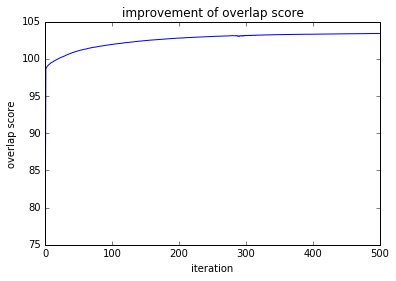

In [65]:
plt.plot(scores);
plt.title('improvement of overlap score');
plt.xlabel('iteration');
plt.ylabel('overlap score');

In [ ]:
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = params_best_upToNow
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (300, -200, -90, np.deg2rad(25), 0)

# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (0, 0, -76, 0, 0)
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (250, -152, -120, np.deg2rad(15), 0)
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (250, -150, -120, np.deg2rad(15), 0)
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (300, -200, -90, np.deg2rad(25), np.deg2rad(5))

# tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best = best_global_params
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best, theta_x_best = (-42.664097869285847, -17.288854747102512, 402.40864840658304, 
#                                                                        np.deg2rad(-25), 0.0, 0.0)

# print tx_best, ty_best, tz_best, theta_z_best, theta_y_best

# cos_z = np.cos(theta_z_best)
# sin_z = np.sin(theta_z_best)
# cos_y = np.cos(theta_y_best)
# sin_y = np.sin(theta_y_best)
# cos_x = np.cos(theta_x_best)
# sin_x = np.sin(theta_x_best)
# Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
# Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
# Rx = np.array([[1, 0, 0], [0, cos_x, -sin_x], [0, sin_x, cos_x]])
# R_best = np.dot(np.dot(Rz, Ry), Rx)   

In [ ]:
v = (0,0,1)
theta = -np.deg2rad(15)
qr = np.cos(theta/2)
qx = np.sin(theta/2)*v[0]
qy = np.sin(theta/2)*v[1]
qz = np.sin(theta/2)*v[2]

tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best = (-50, -50, 400, qr, qx, qy, qz)
R_best = quarternion_to_matrix(qr_best, qx_best, qy_best, qz_best)

In [66]:
tx_best, ty_best, tz_best, qr_best, qx_best, qy_best, qz_best = best_global_params
R_best = quarternion_to_matrix(qr_best, qx_best, qy_best, qz_best)

In [67]:
atlas_nzs_projected_to_test = [(np.dot(R_best, vs - atlas_centroid[:, np.newaxis]) + \
                                            np.asarray([tx_best + test_cx, 
                                                        ty_best + test_cy, 
                                                        tz_best + test_cz])[:,np.newaxis]).astype(np.int)
                                for vs in atlas_nzs]

In [68]:
print np.min(atlas_nzs_projected_to_test[0], axis=1)
print np.max(atlas_nzs_projected_to_test[0], axis=1)

[172 104  33]
[306 355 474]


In [69]:
test_volume_atlas_projected = np.zeros_like(volume2_allLabels[0], np.int)

In [70]:
for l in range(1, 10):
    
    test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[l-1].astype(np.int)
    
    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
        (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)
    
    atlas_xs, atlas_ys, atlas_zs = atlas_nzs[l-1]
    
    test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
    volume1[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]

In [71]:
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[label_dict['BackG']] = 1.

In [72]:
bp.pack_ndarray_file(test_volume_atlas_projected, 
                     volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

In [87]:
atlasAlignParams_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams'
if not os.path.exists(atlasAlignParams_dir):
    os.makedirs(atlasAlignParams_dir)

In [89]:
np.savetxt(os.path.join(atlasAlignParams_dir, '%(stack)s_3dAlignParams.txt' % {'stack':stack}),
           best_global_params, fmt='%f')

In [75]:
annotationsViz_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_annotaionsPojectedViz'
annotationsViz_dir = annotationsViz_rootdir + '/' + stack
if not os.path.exists(annotationsViz_dir):
    os.makedirs(annotationsViz_dir)

In [79]:
for z in range(0, test_zdim, 10):
#     viz1 = plt.cm.hot(volume2_allLabels[label_dict['5N']-1][...,i])
#     viz1 = cropped_imgs[map_z_to_section[z]]
    print z

    dm = DataManager(stack=stack, section=map_z_to_section[z])
    dm._load_image(versions=['rgb-jpg'])
    viz1 = dm.image_rgb_jpg[::downsample_factor, ::downsample_factor][volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1]
    
    viz2 = colors[test_volume_atlas_projected[...,z]]
    viz = alpha_blending(viz2, viz1[...,:3], .2, 1.)
    
#     plt.figure(figsize=(15,15));
#     plt.title('section = %d, z = %.2f'%(map_z_to_section[z], z))
#     plt.imshow(viz);
#     plt.show();
    
    cv2.imwrite(annotationsViz_dir + '/%(stack)s_%(sec)04d_annotationsProjectedViz_z%(z)04d.jpg' % \
                {'stack': stack, 'sec': map_z_to_section[z], 'z': z}, 
                img_as_ubyte(viz[..., [2,1,0,3]]))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [118]:
from skimage.measure import find_contours

def find_contour_points(labelmap):
    '''
    return is (x,y)
    '''

    regions = regionprops(labelmap)

    contour_points = {}

    for r in regions:

        (min_row, min_col, max_row, max_col) = r.bbox

        padded = np.pad(r.filled_image, ((5,5),(5,5)), mode='constant', constant_values=0)

        contours = find_contours(padded, .5, fully_connected='high')
        contours = [cnt.astype(np.int) for cnt in contours if len(cnt) > 10]
        if len(contours) > 1:
            sys.stderr.write('region has more than one part\n')
        elif len(contours) == 0:
            sys.stderr.write('no contour is found\n')

        pts = contours[0] - (5,5)

        pts_sampled = pts[np.arange(0, pts.shape[0], 10)]

    #         viz = np.zeros_like(r.filled_image)
    #         viz[pts_sampled[:,0], pts_sampled[:,1]] = 1
    #         plt.imshow(viz, cmap=plt.cm.gray);
    #         plt.show();

        contour_points[r.label] = pts_sampled[:, ::-1] + (min_col, min_row)
        
    return contour_points